In [15]:
import os
import albumentations as A
import cv2
import json
from matplotlib import pyplot as plt
import copy
import tqdm

In [238]:
class BboxAugmentator():
    def __init__(self, path2images, path2annotations, output_dir=None):
        """
        1) path2images (str): path to images folder or one image
        2) path2annotations (str): path to annotations for images
        """
        self.path2images = path2images
        self.path2annotations = path2annotations
        self.output_dir = output_dir
        self.new_annotations = None
        self.format = 'coco'
    
        self.transform = self.init_transform()
    
    def init_transform(self, width=300, height=300, format='coco', min_area=300, min_visibility=0.2):
        """
        Initialization of transform type and options:
        1)
        2)
        3)
        4)
        5)
        """
        self.format = format
        transform = A.Compose([
            A.RandomCrop(width=width, height=height),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Affine(rotate=[-90, 90]),
            A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5)
        ], bbox_params=A.BboxParams(format=format, min_area=min_area, min_visibility=min_visibility))
        return transform
    
    def forward(self, aug_number=1, RESULT_PRESENT=False, color=(0,0,255)):
        with open(self.path2annotations, 'r') as f:
            annotations = json.load(f)
        if self.output_dir:
            self.new_annotations = copy.deepcopy(annotations)
            if not os.path.exists(self.output_dir):
                os.mkdir(self.output_dir)
            
        IMG_TYPES = ['jpeg', 'jpg', 'png', 'bmp']
        assert os.path.isdir(self.path2images), "Selected Path is not dir"
        images = os.listdir(self.path2images)
        del_list = []
        num_images = len(images)
        for i in range(num_images):
            if images[i].split('.')[-1] not in IMG_TYPES:
                del_list.append(i)
        for index in del_list[::-1]:
            images.pop(index)
        assert num_images > 0, "No images ['jpeg', 'jpg', 'png', 'bmp']"
            
        progress_bar = tqdm.trange(num_images)
        for img, _ in zip(images, progress_bar):
            aim_anno = self.read_annotations(img, annotations)
            if not aim_anno:
                continue
            image = cv2.imread(os.path.join(self.path2images, img))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            transformed_images = []
            transformed_bboxes = []
            for i in range(aug_number):
                transformed = self.transform(image=image, bboxes=aim_anno)
                transformed_images.append(transformed['image'])
                transformed_bboxes.append(transformed['bboxes'])
            if RESULT_PRESENT == True:
                self.result_present(image, aim_anno, transformed_images, transformed_bboxes, color=color)
            if self.output_dir:
                self.data_save(transformed_images, transformed_bboxes, image_name=img)
        if self.output_dir:
            with open(f"{self.output_dir}/aug.json", 'w') as f:
                json.dump(self.new_annotations, f)
        print("==> Augmentation complete <==")
                
    def read_annotations(self, image_name, annotations):
        aim_anno = []
        image_id = None
        for img in annotations["images"]:
            if img["file_name"] == image_name:
                image_id = img['id']
                break
        if not image_id:
            return None
        for anno in annotations["annotations"]:
            if anno['image_id'] == image_id:
                aim_anno.append(anno['bbox'] + [anno['category_id']])
        for bbox in aim_anno:
            for obj in annotations['categories']:
                if bbox[-1] == obj['id']:
                    bbox[-1] = obj['name']
                    break
        return aim_anno            
    
    def draw_bbox(self, img, bboxes, color=(0,0,255), thickness=2):
        for bbox in bboxes:
            x, y = list(map(int, bbox[:2]))
            w, h = list(map(int, bbox[2:4]))
            img = cv2.rectangle(img, (x, y), (x+w, y+h), color=color, thickness=thickness)
        return img

    def result_present(self, stock_image, aim_anno, transformed_images, transformed_bboxes, color=(0,0,255), thickness=2):
        plt.suptitle("Stock", fontsize=16)
        print("Stock bboxes:", aim_anno)
        plt.plot()
        img_with_bbox = self.draw_bbox(stock_image, aim_anno, color, thickness)    
        plt.imshow(img_with_bbox)
        plt.show()

        num_images = len(transformed_images)
        m = int(num_images**(1/2)) + 1
        n = m * 4
        plt.figure(figsize=(n, n))
        plt.suptitle("Augmented", fontsize=16)
        print("Augmented bboxes:")
        for i in range(num_images):
            print(f'{i+1})', transformed_bboxes[i])
            plt.subplot(m, m, i+1)
            img_with_bbox = self.draw_bbox(transformed_images[i], transformed_bboxes[i], color, thickness)
            plt.imshow(transformed_images[i])
        plt.show()
        
    def data_save(self, transformed_images, transformed_bboxes, image_name):
        num_images = len(self.new_annotations['images'])
        num_anno = len(self.new_annotations['annotations'])
        for image, bboxes, i in zip(transformed_images, transformed_bboxes, range(len(transformed_images))):
            new_name = f"{image_name.split('.')[0]}_{i+1}.png"
            height, width, channels = image.shape
            cv2.imwrite(os.path.join(self.output_dir, new_name), image)
                        
            image_id = self.new_annotations['images'][-1]['id'] + 1
            self.new_annotations['images'].append({
                'id': image_id,
                'width':width,
                'height':height,
                'file_name':new_name,
                'license':0,
                'flickr_url':"",
                'coco_url':"",
                'date_captured':0
            })
                                                               
            for bbox in bboxes:
                if self.format == 'coco':
                    area = bbox[2] * bbox[3]
                elif self.format == 'yolo':
                    area = bbox[2] * bbox[3]
                elif self.format == 'albumentations':
                    area = width*(bbox[2]-bbox[0])*height*(bbox[3]-bbox[1])
                elif self.format == 'pascal_voc':
                    area = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])                
                
                for category in self.new_annotations['categories']:
                    if bbox[-1] == category['name']:
                        category_id = category['id']
                        break                
                self.new_annotations['annotations'].append({
                    "id": self.new_annotations['annotations'][-1]['id'] + 1, 
                    "image_id": image_id, 
                    "category_id": category_id, 
                    "segmentation": [], 
                    "area": area, 
                    "bbox": bbox[:-1], 
                    "iscrowd": 0, 
                    "attributes": {"occluded": False} 
                })                                   

In [ ]:
class KeypointsBboxAugmentator():
    def __init__(self, path2images, path2annotations, output_dir=None):
        """
        1) path2images (str): path to images folder or one image
        2) path2annotations (str): path to annotations for images
        """
        self.path2images = path2images
        self.path2annotations = path2annotations
        self.output_dir = output_dir
        self.new_annotations = None
        self.format = 'coco'
    
        self.transform = self.init_transform()
    
    # Initialization augmentation pipeline
    def init_transform(self, transform='default', width=300, height=300, format='coco', min_area=300, min_visibility=0.2):
        """
        Initialization of transform type and options:
        1) transform (str | obj A.Compose): default transform pipeline or custom pipeline
        2) width (int): width of crop, default=300
        3) height (int): height of crop, default=300
        4) format (str): type of input bboxes data - [coco, yolo, albumentations, pascal_voc], default='coco'
        5) min_area (int): minimal bbox area for annotation after augmentation, default=300
        6) min_visibility (float): minimal part of original bbox that will be annotated after augmentation in range [0, 1], default=0.2
        """
        
        self.format = format
        transform = transform
        if transform == 'default':
            transform = A.Compose([
                A.RandomCrop(width=width, height=height),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Affine(rotate=[-90, 90]),
                A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5)
            ], bbox_params=A.BboxParams(format=format, min_area=min_area, min_visibility=min_visibility),
               keypoint_params=A.KeypointParams(format='xy'))
        return transform
    
    # Run augmentation
    def forward(self, aug_number=1, RESULT_PRESENT=False, color=(0,0,255)):
        with open(self.path2annotations, 'r') as f:
            annotations = json.load(f)
        if self.output_dir:
            self.new_annotations = copy.deepcopy(annotations)
            if not os.path.exists(self.output_dir):
                os.mkdir(self.output_dir)
            
        IMG_TYPES = ['jpeg', 'jpg', 'png', 'bmp']
        assert os.path.isdir(self.path2images), "Selected Path is not dir"
        images = os.listdir(self.path2images)
        del_list = []
        num_images = len(images)
        for i in range(num_images):
            if images[i].split('.')[-1] not in IMG_TYPES:
                del_list.append(i)
        for index in del_list[::-1]:
            images.pop(index)
        assert num_images > 0, "No images ['jpeg', 'jpg', 'png', 'bmp']"
            
        progress_bar = tqdm.trange(num_images)
        for img, _ in zip(images, progress_bar):
            aim_anno = self.read_annotations(img, annotations)
            if not aim_anno:
                continue
            image = cv2.imread(os.path.join(self.path2images, img))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            transformed_images = []
            transformed_mask = []
            transformed_bboxes = []
            transformed_keypoints = []
            for i in range(aug_number):
                transformed = self.transform(image=image,
#                                              mask=aim_anno['segmentation'],
                                             bboxes=aim_anno['bboxes'],
                                             keypoints=aim_anno['keypoints']
                                            )
                transformed_images.append(transformed['image'])
#                 transformed_mask.append(transformed["mask"])                             
                transformed_mask.append(None)                             
                transformed_bboxes.append(transformed['bboxes'])
                transformed_keypoints.append(transformed["keypoints"])
                print(i, ')', len(transformed_keypoints[i]), transformed_keypoints[i])
                
            if RESULT_PRESENT == True:
                self.result_present(image, aim_anno, transformed_images, 
                                    transformed_bboxes, transformed_mask, 
                                    transformed_keypoints, bbox_color=color
                                   )
            if self.output_dir:
                self.data_save(transformed_images, transformed_bboxes, 
                               transformed_keypoints, image_name=img
                              )
        if self.output_dir:
            with open(f"{self.output_dir}/aug.json", 'w') as f:
                json.dump(self.new_annotations, f)
        print("==> Augmentation complete <==")
    
    # Read annotations file and memorize need annotations (bbox, keypoints)
    def read_annotations(self, image_name, annotations):
        aim_anno = {'bboxes':[], 'segmentation':[], 'keypoints':[], 'num_keypoints':[]}
        image_id = None
        for img in annotations["images"]:
            if img["file_name"] == image_name:
                image_id = img['id']
                break
        if not image_id:
            return None
        for anno in annotations["annotations"]:
            if anno['image_id'] == image_id:
                aim_anno['bboxes'].append(anno['bbox'] + [anno['category_id']])
                if anno['segmentation'] is not []:
                    aim_anno['segmentation'].append(anno['segmentation'])
                else:
                    aim_anno['segmentation'].append(None)
                if 'keypoints' in anno:
                    for x, y in zip(anno['keypoints'][0::3], anno['keypoints'][1::3]):                
                        aim_anno['keypoints'].append([x,y])
                    aim_anno['num_keypoints'].append(anno['num_keypoints'])
                else:
                    aim_anno['keypoints'].append(None)
                    aim_anno['num_keypoints'].append(None)
                    
        for bbox in aim_anno['bboxes']:
            for obj in annotations['categories']:
                if bbox[-1] == obj['id']:
                    bbox[-1] = obj['name']
                    break
        return aim_anno            
    
    # Draw rectangle on image
    def draw_bbox(self, img, bboxes, color=(0,0,255), thickness=2):
        for bbox in bboxes:
            x, y = list(map(int, bbox[:2]))
            w, h = list(map(int, bbox[2:4]))
            img = cv2.rectangle(img, (x, y), (x+w, y+h), color=color, thickness=thickness)
        return img
    
    def draw_kpt(self, image, kpts, color=(255,255,0), thickness=2):
        """Наносит на изображение набор точек"""
        drawed_img = image
        print('kpts:', kpts)
        for x, y in kpts[::]:
            drawed_img = cv2.drawMarker(drawed_img, tuple(map(int, [x, y])), color=color, 
                                        markerType=cv2.MARKER_CROSS, thickness=thickness)
        return drawed_img

    # Draw original images and augmentation results 
    def result_present(self, stock_image, aim_anno, 
                       transformed_images, transformed_bboxes, 
                       transformed_mask, transformed_keypoints, 
                       bbox_color=(0,0,255), thickness=2
                      ):
        plt.suptitle("Stock", fontsize=16)
        img_with_bbox = self.draw_bbox(stock_image, aim_anno['bboxes'], bbox_color, thickness)    
        img_with_kp = self.draw_kpt(img_with_bbox, aim_anno['keypoints'])    
        plt.imshow(img_with_kp)
        plt.show()

        num_images = len(transformed_images)
        m = int(num_images**(1/2)) + 1
        n = m * 4
        plt.figure(figsize=(n, n))
        plt.suptitle("Augmented", fontsize=16)
        for i in range(num_images):
            plt.subplot(m, m, i+1)
            img_with_bbox = self.draw_bbox(transformed_images[i], transformed_bboxes[i], bbox_color, thickness)
            if transformed_keypoints[i]:
                img_with_kp = self.draw_kpt(img_with_bbox, transformed_keypoints[i])
            else:
                img_with_kp = img_with_bbox 
            plt.imshow(img_with_kp)
        plt.show()
        
    # Save augmentated images and new annotations    
    def data_save(self, transformed_images, transformed_bboxes, 
                  transformed_keypoints, image_name):
        num_images = len(self.new_annotations['images'])
        num_anno = len(self.new_annotations['annotations'])
        for image, bboxes, keypoints, i in zip(transformed_images, 
                                               transformed_bboxes, 
                                               transformed_keypoints, 
                                               range(len(transformed_images))
                                              ):
            new_name = f"{image_name.split('.')[0]}_{i+1}.png"
            height, width, channels = image.shape
            cv2.imwrite(os.path.join(self.output_dir, new_name), image)
                        
            image_id = self.new_annotations['images'][-1]['id'] + 1
            self.new_annotations['images'].append({
                'id': image_id,
                'width':width,
                'height':height,
                'file_name':new_name,
                'license':0,
                'flickr_url':"",
                'coco_url':"",
                'date_captured':0
            })
                                                               
            for bbox, keypoint in zip(bboxes, keypoints):
                if self.format == 'coco':
                    area = bbox[2] * bbox[3]
                elif self.format == 'yolo':
                    area = bbox[2] * bbox[3]
                elif self.format == 'albumentations':
                    area = width*(bbox[2]-bbox[0])*height*(bbox[3]-bbox[1])
                elif self.format == 'pascal_voc':
                    area = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])                
                
                for category in self.new_annotations['categories']:
                    print(bbox[-1], category)    
                    if bbox[-1] == category['name']:
                        category_id = category['id']
                        break                
#                 if segment == None:
#                     segmentation = []
#                 else:
#                     segmentation = segment
                self.new_annotations['annotations'].append({
                    "id": self.new_annotations['annotations'][-1]['id'] + 1, 
                    "image_id": image_id, 
                    "category_id": category_id, 
                    "segmentation": [], 
                    "area": area, 
                    "bbox": bbox[:-1], 
                    "iscrowd": 0, 
                    "attributes": {"occluded": False},
                    "keypoints": keypoint,
                    "num_keypoints": len(keypoint)/2
                })                                   

In [243]:
# path2images = '../../mmdetection/datasets/ba2/val'
# path2annotations = '../../mmdetection/datasets/ba2/val.json'
path2images = '../data/pprofile_test/images'
path2annotations = '../data/pprofile_test/val.json'
# output_dir = '../data/pprofile_test/aug_images'
output_dir = None
augmentator = BboxAugmentator(path2images, path2annotations, output_dir)

  0% 0/39 [00:00<?, ?it/s]

Stock bboxes: [[204.41, 229.15, 166.65, 39.53, 'pprofile']]


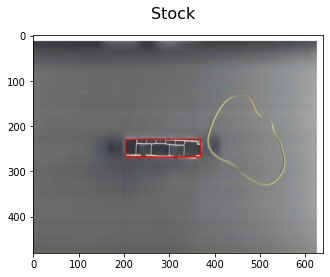

Augmented bboxes:
1) [(48.940000000000005, 203.15, 166.65, 39.53, 'pprofile')]
2) [(108.85382058341995, 3.027472610188411, 150.29425385580444, 140.88898524182417, 'pprofile')]
3) [(217.93999999999997, 137.15, 82.06000000000003, 39.53, 'pprofile')]
4) [(15.538886829594361, 20.144855912215228, 78.4772258347152, 171.26532500875672, 'pprofile')]
5) [(249.94, 206.15, 50.06, 39.53, 'pprofile')]


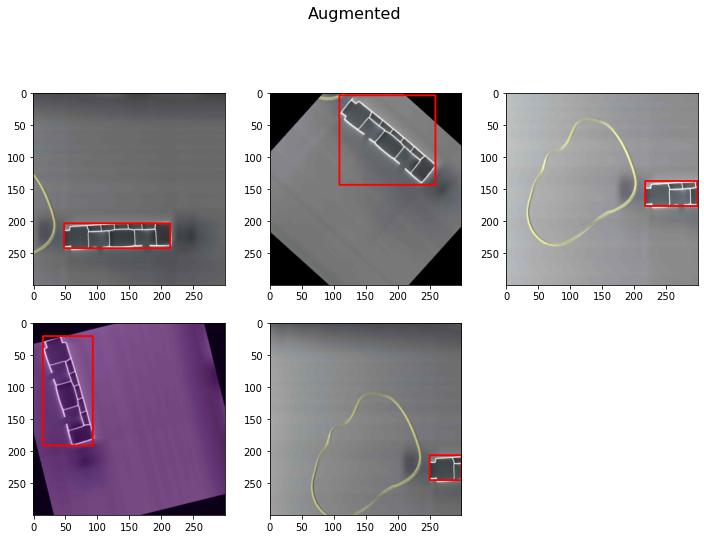

  5% 2/39 [00:00<00:10,  3.43it/s]

Stock bboxes: [[149.62, 232.08, 142.68, 133.28, 'pprofile'], [126.02, 264.48, 144.02, 132.7, 'pprofile']]


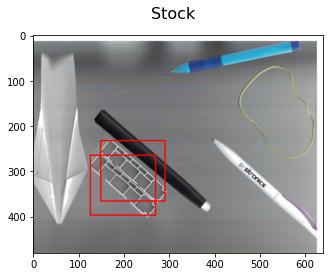

Augmented bboxes:
1) [(215.7, 70.08000000000001, 84.30000000000001, 133.28, 'pprofile'), (237.95999999999998, 102.48000000000002, 62.04000000000002, 132.7, 'pprofile')]
2) [(53.35506003630583, 232.21629133187432, 139.53412178352488, 67.78370866812568, 'pprofile'), (68.4489195062291, 271.25574768911133, 104.74331178099133, 28.74425231088867, 'pprofile')]
3) []
4) [(15.700000000000003, 176.08, 142.68, 123.91999999999999, 'pprofile'), (37.95999999999998, 208.48000000000002, 144.02000000000004, 91.51999999999998, 'pprofile')]
5) [(27.049621343486912, 168.77480924952556, 172.44008044141796, 131.22519075047444, 'pprofile'), (20.977122476939286, 206.05950875181298, 157.11693021716903, 93.94049124818702, 'pprofile')]


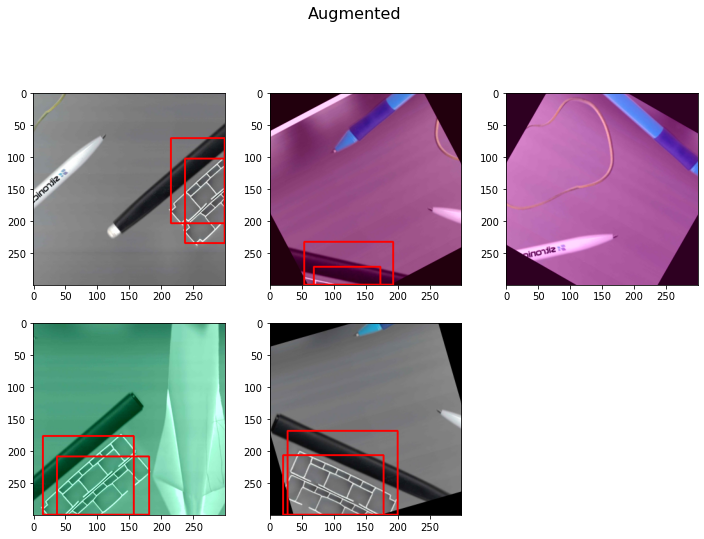

 13% 5/39 [00:01<00:07,  4.45it/s]

Stock bboxes: [[222.14, 252.41, 167.05, 38.37, 'pprofile']]


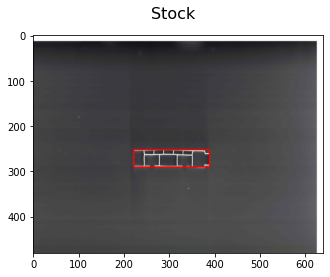

Augmented bboxes:
1) [(90.81000000000006, 198.40999999999997, 167.04999999999995, 38.370000000000005, 'pprofile')]
2) [(0.0, 89.05805287054721, 107.21271646575403, 49.97924969767564, 'pprofile')]
3) [(169.8100000000001, 147.40999999999997, 130.1899999999999, 38.369999999999976, 'pprofile')]
4) [(202.322760134662, 108.43779516262121, 97.67723986533801, 54.18285196286645, 'pprofile')]
5) [(98.63476904386019, 215.44411447723212, 68.63366274908006, 84.55588552276788, 'pprofile')]


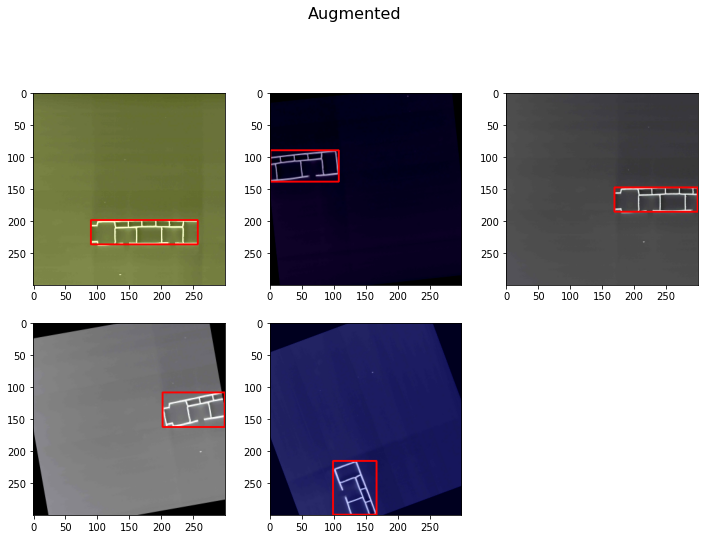

 21% 8/39 [00:01<00:06,  4.88it/s]

Stock bboxes: [[229.41, 119.64, 140.55, 135.1, 'pprofile'], [529.07, 115.05, 34.08, 169.52, 'pprofile']]


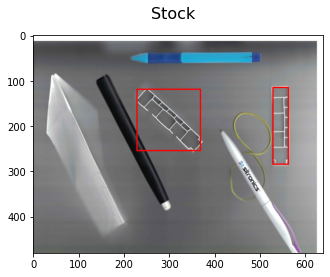

Augmented bboxes:
1) [(97.45641126878621, 29.51018023533778, 154.26798259104987, 149.4359037071085, 'pprofile')]
2) [(156.85284266014165, 45.438779913878314, 143.14715733985835, 174.1443506060814, 'pprofile')]
3) [(77.03999999999998, 20.64, 140.55, 135.10000000000002, 'pprofile')]
4) [(0.0, 3.6400000000000006, 117.59, 135.10000000000002, 'pprofile')]
5) [(5.89911527922564, 40.009163013165875, 185.18385178378725, 187.44779097816337, 'pprofile')]


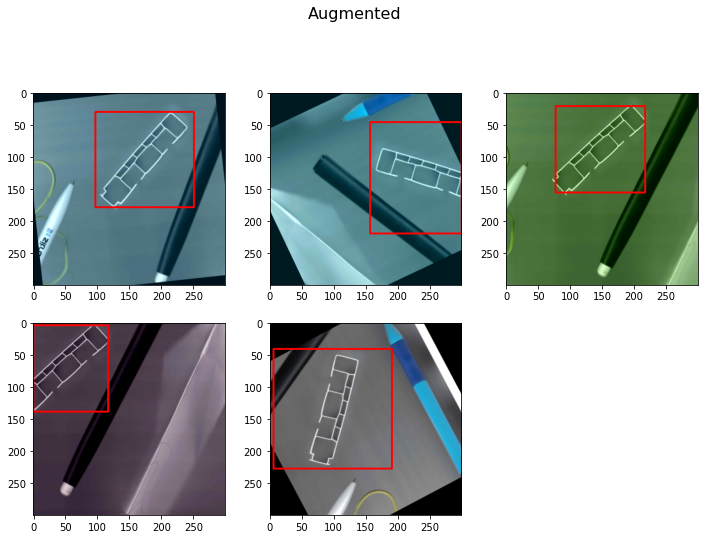

 26% 10/39 [00:02<00:06,  4.31it/s]

Stock bboxes: [[133.51, 38.93, 134.15, 142.36, 'pprofile'], [121.43, 229.35, 165.03, 39.46, 'pprofile'], [373.47, 99.46, 165.05, 40.52, 'pprofile'], [363.13, 197.47, 132.0, 144.83, 'pprofile']]


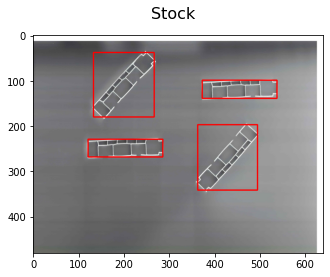

Augmented bboxes:
1) [(0.0, 18.977082758267727, 83.19604777769032, 139.18755031245894, 'pprofile'), (120.02966160799312, 15.807940996739717, 51.33227280479704, 167.45849622267056, 'pprofile'), (79.77634840223692, 254.55709704545893, 147.34151186025693, 45.44290295454107, 'pprofile')]
2) [(0.0, 57.08574480442829, 64.58933726664112, 169.73646198735727, 'pprofile'), (84.75647977437455, 75.30077935761534, 176.6133443175093, 168.00384829164076, 'pprofile')]
3) [(0.0, 107.51939345024978, 50.38940874592553, 138.01576807734534, 'pprofile'), (83.79330612697187, 104.49621853801868, 54.86569292448387, 168.01851162671477, 'pprofile')]
4) [(7.9248286150458895, 194.12264641046238, 51.528379740909465, 47.644237248372804, 'pprofile'), (110.3743607778386, 15.89015173453591, 169.8355924896278, 73.09713957050961, 'pprofile'), (120.09177012341044, 120.65519528737762, 158.58883036524392, 168.555540001093, 'pprofile')]
5) [(52.1739293063042, 0.0, 161.12108363255726, 146.79079649825377, 'pprofile'), (75.8149

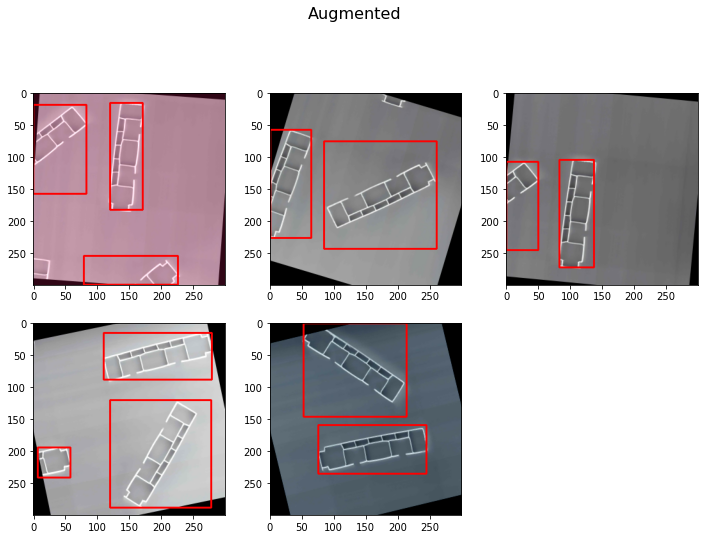

 38% 15/39 [00:03<00:04,  4.88it/s]

Stock bboxes: [[230.54, 250.97, 167.06, 37.61, 'pprofile']]


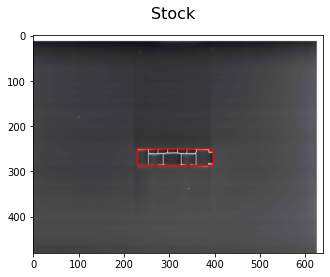

Augmented bboxes:
1) [(236.94273580661653, 154.47051022443657, 63.057264193383475, 86.36595401654466, 'pprofile')]
2) [(99.22473818652331, 0.0, 40.70337184495402, 138.31554063694207, 'pprofile')]
3) [(71.39999999999996, 129.96999999999997, 167.06000000000006, 37.610000000000014, 'pprofile')]
4) [(0.0, 245.96999999999994, 84.60000000000002, 37.61000000000004, 'pprofile')]
5) [(225.39999999999998, 155.96999999999997, 74.60000000000002, 37.610000000000014, 'pprofile')]


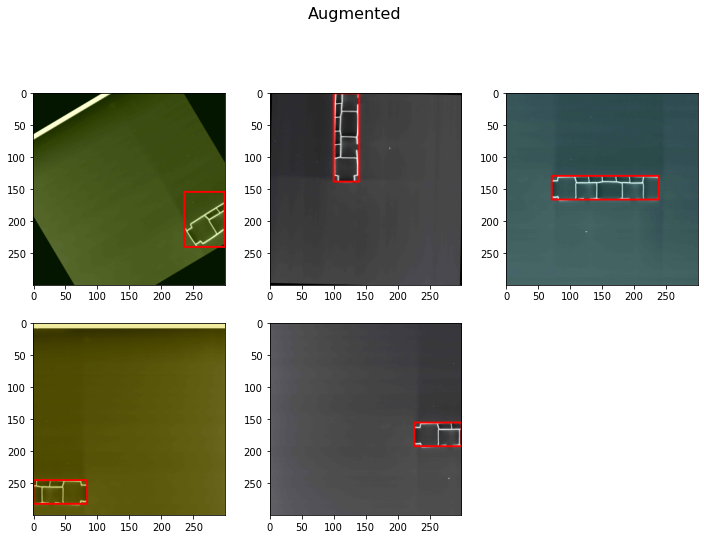

 44% 17/39 [00:03<00:04,  4.52it/s]

Stock bboxes: [[234.39, 254.44, 166.09, 37.75, 'pprofile']]


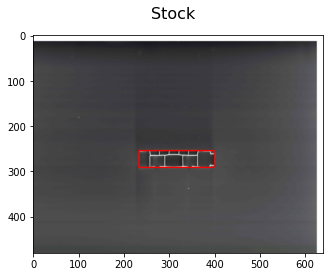

Augmented bboxes:
1) [(115.20209544928012, 90.42058509105439, 148.12925737110135, 139.8434881351683, 'pprofile')]
2) [(0.0, 160.43999999999997, 65.61, 37.75000000000003, 'pprofile')]
3) [(0.0, 226.44, 115.61000000000003, 37.75, 'pprofile')]
4) [(42.389999999999986, 218.44, 166.09000000000003, 37.75, 'pprofile')]
5) [(0.0, 171.44, 134.48000000000002, 37.75, 'pprofile')]


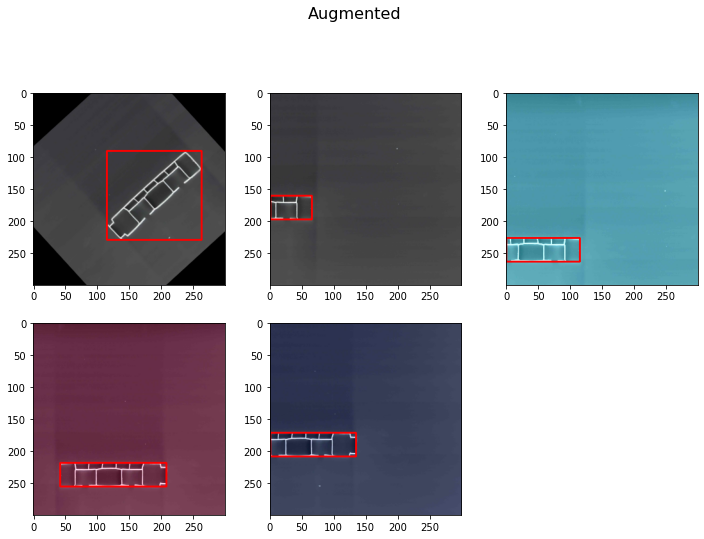

 49% 19/39 [00:04<00:04,  4.25it/s]

Stock bboxes: [[205.32, 229.51, 164.44, 37.68, 'pprofile']]


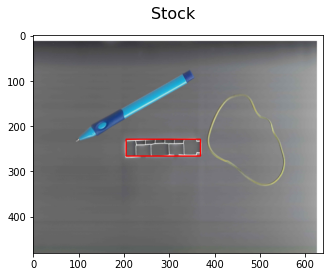

Augmented bboxes:
1) [(90.24000000000002, 107.50999999999998, 164.44, 37.68000000000002, 'pprofile')]
2) [(15.24000000000002, 147.51, 164.44, 37.68000000000001, 'pprofile')]
3) [(265.24, 68.50999999999999, 34.75999999999999, 37.68000000000001, 'pprofile')]
4) [(114.68586736759369, 216.09141474592698, 77.34804215379813, 83.90858525407302, 'pprofile')]
5) [(103.01745960187094, 0.0, 79.80248305331341, 72.1486494692428, 'pprofile')]


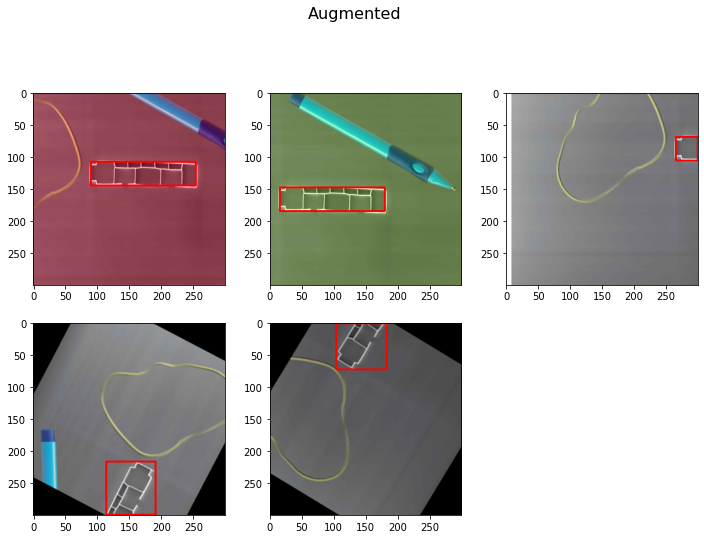

 56% 22/39 [00:04<00:03,  4.61it/s]

Stock bboxes: [[226.5, 88.68, 167.72, 51.4, 'pprofile'], [322.34, 235.93, 158.49, 104.27, 'pprofile']]


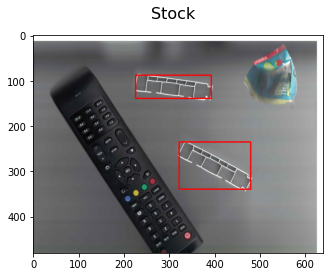

Augmented bboxes:
1) [(52.77999999999998, 81.68, 167.72000000000003, 51.400000000000006, 'pprofile'), (0.0, 228.93, 124.6600000000001, 71.07, 'pprofile')]
2) [(242.33999999999992, 93.93, 57.66000000000008, 104.26999999999998, 'pprofile')]
3) [(78.33999999999992, 55.93000000000001, 158.49000000000007, 104.26999999999998, 'pprofile')]
4) [(198.7021446151491, 136.76174603049975, 90.71197175458923, 140.7696379645833, 'pprofile'), (0.0, 101.86360237635608, 130.91603633372847, 182.1885390492871, 'pprofile')]
5) [(0.0, 55.68000000000001, 115.22000000000003, 51.400000000000006, 'pprofile'), (43.33999999999992, 202.93, 158.49000000000007, 97.07, 'pprofile')]


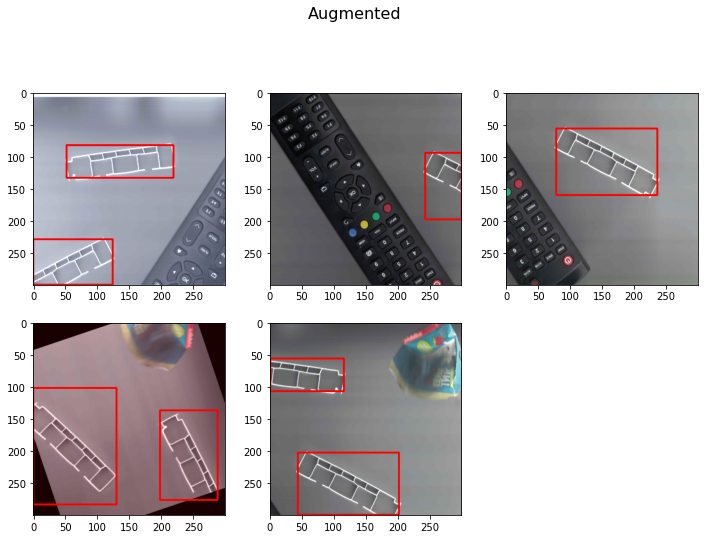

 62% 24/39 [00:05<00:03,  4.28it/s]

Stock bboxes: [[56.65, 57.67, 128.2, 148.78, 'pprofile'], [455.18, 105.82, 105.05, 162.76, 'pprofile'], [190.5, 187.41, 125.81, 150.17, 'pprofile']]


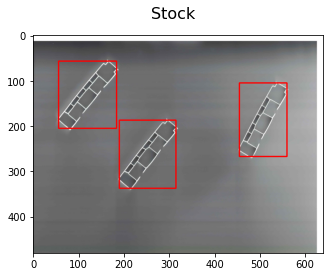

Augmented bboxes:
1) [(53.64999999999999, 18.67, 128.2, 148.77999999999997, 'pprofile'), (187.5, 148.41, 112.5, 150.17, 'pprofile')]
2) [(3.891608536730944, 0.0, 125.3856814962679, 26.103677425715034, 'pprofile'), (39.040821994600215, 162.3794678523734, 154.0138025596975, 130.42396005374735, 'pprofile')]
3) [(53.5, 54.41, 125.81, 150.17, 'pprofile')]
4) [(0.0, 103.82, 62.82000000000001, 162.76, 'pprofile'), (201.69, 185.41, 98.31, 114.59, 'pprofile')]
5) [(169.04988923246935, 181.1807360142018, 127.74340121502928, 118.81926398579819, 'pprofile'), (0.0, 89.550142676675, 106.42369483386634, 164.81002372770317, 'pprofile')]


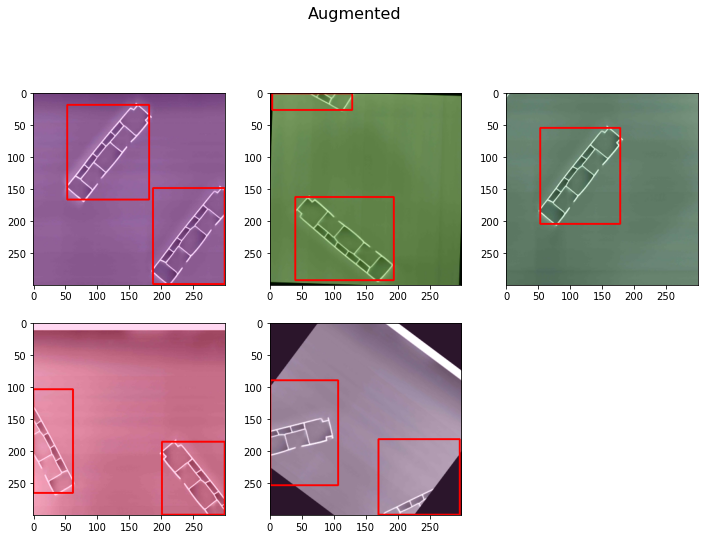

 69% 27/39 [00:05<00:02,  4.60it/s]

Stock bboxes: [[150.78, 275.16, 152.62, 120.85, 'pprofile'], [307.01, 41.34, 145.87, 128.82, 'pprofile']]


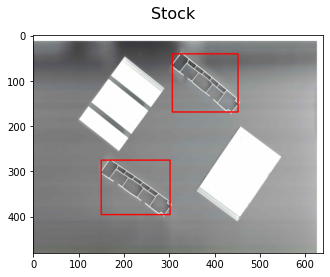

Augmented bboxes:
1) [(0.0, 107.16000000000003, 61.39999999999998, 120.84999999999997, 'pprofile')]
2) [(159.5853386032672, 63.604306124172815, 140.4146613967328, 181.29476790673456, 'pprofile'), (0.0, 26.140431267507385, 94.14670656422004, 126.37031596695982, 'pprofile')]
3) [(183.4436312219035, 214.08038988091184, 116.5563687780965, 80.07680791641846, 'pprofile')]
4) [(87.78, 137.16000000000003, 152.61999999999998, 120.84999999999997, 'pprofile')]
5) [(28.600000000000016, 249.16000000000003, 152.61999999999998, 50.839999999999975, 'pprofile')]


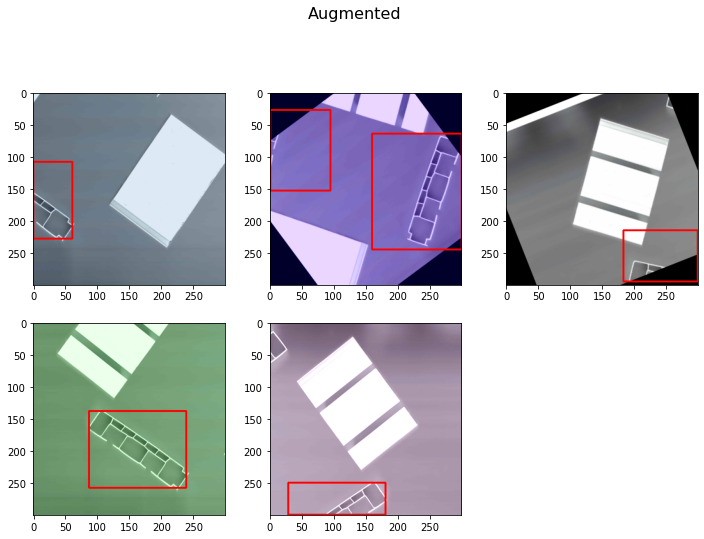

 82% 32/39 [00:06<00:01,  5.93it/s]

Stock bboxes: [[141.92, 266.18, 165.33, 79.0, 'pprofile'], [206.43, 73.15, 158.32, 105.62, 'pprofile']]


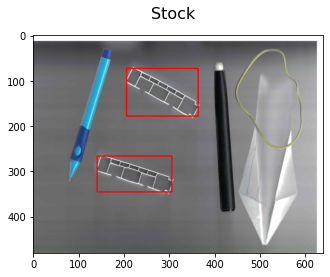

Augmented bboxes:
1) [(107.74999999999999, 159.18000000000004, 165.32999999999998, 78.99999999999997, 'pprofile'), (50.24999999999999, 0.0, 158.32000000000002, 71.77000000000001, 'pprofile')]
2) [(10.117113935668797, 139.98119133250742, 176.49840675822117, 106.39358152855746, 'pprofile'), (48.7290767402102, 0.0, 165.75071786532106, 71.3177406260241, 'pprofile')]
3) [(0.0, 33.99163686102018, 112.33757069473425, 118.96705897942884, 'pprofile')]
4) [(75.85939253091124, 129.43748596942964, 87.81410421373602, 169.3554472436498, 'pprofile'), (238.92094950281415, 64.28831388866266, 61.07905049718585, 161.10103532770196, 'pprofile')]
5) [(0.0, 125.27038464131272, 167.7173460978711, 173.72245461010118, 'pprofile'), (75.48490416554763, 0.0, 186.0133244441675, 136.88209679572756, 'pprofile')]


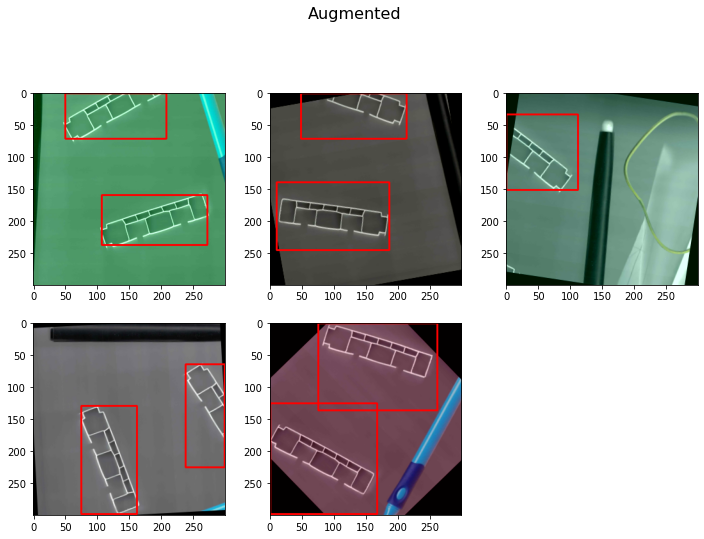

 95% 37/39 [00:07<00:00,  5.22it/s]

==> Augmentation complete <==


In [244]:
augmentator.forward(aug_number=5, RESULT_PRESENT=True, color=(255,0,0))

640 480 648


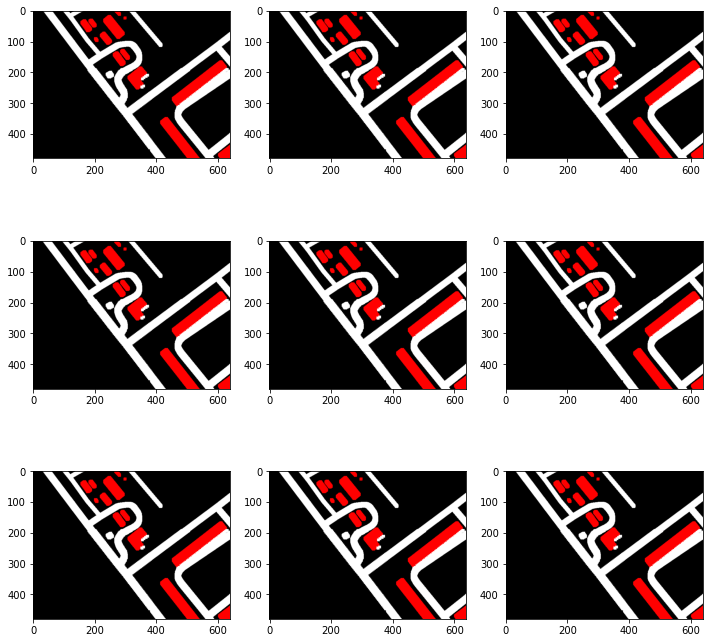

In [112]:
im = cv2.imread(path2images+'/'+'19.png')
height, width, _ = im.shape
print(width, height, 72*n)
n = 12
m = 3
plt.figure(figsize=(n,n))
for i in range(m**2):
    plt.subplot(m,m,i+1)
    plt.imshow(im)
